In [3]:
import os,sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import datetime

In [2]:
mkdir /scr/tmp/mhayman/ptv-c2f-hr_paper_data

### Function Definitions for Analysis and Plotting

In [4]:
def mesh_axis(ax_arr:np.ndarray,scale='linear')->np.ndarray:
    """
    Creates a plotting axis use in pcolormesh()
    from a coordinate array corresponding to the
    data points.

    Inputs:
        ax_arr - 1D input array
        scale- 'linear' or 'log'
            defaults to 'linear'
    Outputs:
        mesh_arr - 1D mesh array

    """
    if scale == 'log':
        ax0_arr = np.log(ax_arr)
    else:
        ax0_arr = ax_arr.copy()

    mesh_arr = np.concatenate([[ax0_arr[0]-0.5*(ax0_arr[1]-ax0_arr[0])],
                            ax0_arr[1:]-0.5*np.diff(ax0_arr),
                        [ax0_arr[-1]+0.5*(ax0_arr[-1]-ax0_arr[-2])]])
    
    if scale == 'log':
        mesh_arr = np.exp(mesh_arr)

    return mesh_arr

In [9]:
def time_up_sample(a:np.ndarray,up_int:int,t_size_int:int=None):
    """
    up sample an array in time (0 axis) by a factor of up_int
    the up sampling is performed by repeating the values
    
    a: np.ndarray
        array to be up sampled
    up_int: int
        up sampling factor
    t_size_int: int
        size of the output array along the time axis
    """
    a_up = np.repeat(a,up_int,axis=0)
    if t_size_int is None:
        return a_up
    else:
        a_up = a_up[:t_size_int,:]
    return a_up

def range_up_sample(a:np.ndarray,up_int:int,r_size_int:int):
    """
    up sample an array in range (1 axis) by a factor of up_int
    the up sampling is performed by repeating the values
    
    a: np.ndarray
        array to be up sampled
    up_int: int
        up sampling factor
    r_size_int: int
        size of the output array along the range axis
    """
    a_up = np.repeat(a,up_int,axis=1)
    if r_size_int is None:
        return a_up
    else:
        a_up = a_up[:,:r_size_int]
    return a_up

# Time Tag Fit Example

In [58]:
save_data_path = os.path.join(os.environ['HOME'],"MPD/ptv_tt_figs",'ptv-c2f-hr_paper') #"/Users/mhayman/Documents/MPD/DataForMLEPaper/"
load_file = "Fit_Results_Datacnt50_20230912T102646_Process20230912T103317.nc"
ds = xr.open_dataset(os.path.join(save_data_path,load_file))

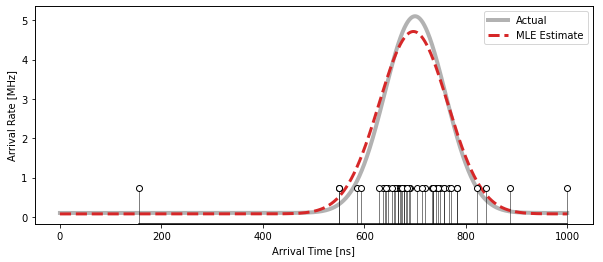

In [59]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax2 = ax.twinx()

stem_color_str = "k"
(markers, stemlines, baseline) = ax2.stem(1e9*ds['t_phot_fit'].values,np.ones(ds['t_phot_fit'].shape),markerfmt='none',basefmt=stem_color_str,bottom=0)
plt.setp(markers, marker='o', markersize=6, markeredgecolor=stem_color_str, markeredgewidth=1,markerfacecolor='w')
plt.setp(stemlines,color=stem_color_str,linewidth=1,alpha=0.5)
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_ylim([0,6])

# ax.bar(1e9*h_phot[1][:-1],1e-6*h_phot[0]/dh_bins/cnt_phot_fit,label='Histogram',
#        align='edge',width=1e9*np.diff(h_phot[1]),
#        facecolor='w',edgecolor='k',linewidth=1.0)

ax.plot(ds['t_sim'].values*1e9,1e-6*ds['photon_rate_arr'].values,label='Actual',color='k',alpha=0.3,linewidth=4)
ax.plot(ds['t_sim'].values*1e9,1e-6*ds['est_photon_rate_arr'].values,'C3--',label=r'MLE Estimate',linewidth=3)

ax.set_ylabel("Arrival Rate [MHz]")
ax.set_xlabel("Arrival Time [ns]")

ax.legend()

# plt.savefig(os.path.join(save_data_path,"Fig1_"+load_file.replace('.nc','.jpg')),dpi=300,bbox_inches='tight')

# Perform Simulated Data Analysis

Analysis used to generate Figures 3 and 4

In [ ]:
data_path = '/scr/sci/mhayman/time_tag_data/'  # set path to simulated data folder

In [10]:
data_file_str = "tcspc/timetag_hist_ptv_rt_sim_20221106T063211_RunOn*.nc"

In [11]:
ptv_file_lst = sorted(glob.glob(data_path+data_file_str))

In [13]:

ptv_vld_raw_lst = []
ptv_rmse_raw_lst = []
ptv_vld_dwnsmp_lst = []
ptv_rmse_dwnsmp_lst = []


mcs_vld_raw_lst = []
mcs_rmse_raw_lst = []
mcs_vld_dwnsmp_lst = []
mcs_rmse_dwnsmp_lst = []

t_res_lst = []
r_res_lst = []

first_bl = True
for file_idx,ptv_file in enumerate(ptv_file_lst):
    ptv_ds = xr.open_dataset(ptv_file)
    res_idx=0
    res_str = str(ptv_ds['resolution_t_set'].values[res_idx])+'x'+str(ptv_ds['resolution_r_set'].values[res_idx])
    tres_str = str(ptv_ds['resolution_t_set'].values[res_idx])
    rres_str = str(ptv_ds['resolution_r_set'].values[res_idx])
    
    print('%d.) '%file_idx+ptv_file.split(os.sep)[-1] + ', ' + res_str)
    if first_bl:
        raw_ds = xr.open_dataset(os.path.join(data_path,'simulations',ptv_ds.attrs['data_filename']))
        
        time_axis_raw = raw_ds.attrs['time_resolution']*np.arange(raw_ds.dims['time1'])
        range_axis_raw = raw_ds.attrs['bin_wid']*np.arange(raw_ds.dims['range1'])
        shot_count_raw = raw_ds['y_i_trn_chan0_res1x1_run0'].values.squeeze()[:,0:1]
        bin_resolution_raw = raw_ds.attrs['bin_wid']  # range bin resolution in s
    
    ### Base (down sampled) resolution analysis
    
    time_axis = ptv_ds.attrs['time_resolution']*ptv_ds['resolution_t_set'].values[res_idx]*np.arange(ptv_ds.dims['time'+tres_str])
    range_axis = ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]*np.arange(ptv_ds.dims['range'+rres_str])
    shot_count = ptv_ds['y_i_trn_chan0_res'+res_str].values.squeeze()[:,0:1]
    bin_resolution = ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]  # range bin resolution in s
    
    rho_est_dwnsmp = ptv_ds['tcspc_sol_backscatter_res'+res_str].values.squeeze()
    hist_est_dwnsmp = ptv_ds['y_p_trn_chan0_res'+res_str].values.squeeze()/shot_count/bin_resolution
    
    ptv_rmse = np.sqrt(np.mean((ptv_ds['x_true_backscatter'+res_str].values-rho_est_dwnsmp)**2))
    hist_rmse = np.sqrt(np.mean((ptv_ds['x_true_backscatter'+res_str].values-hist_est_dwnsmp)**2))
    
    ptv_vld = np.sum(ptv_ds['y_i_vld_chan1_res'+res_str].values.squeeze()*rho_est_dwnsmp*ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]
                     - ptv_ds['y_p_vld_chan1_res'+res_str].values.squeeze()*np.log(rho_est_dwnsmp))
    hist_vld = np.sum(ptv_ds['y_i_vld_chan1_res'+res_str].values.squeeze()*hist_est_dwnsmp*ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]
                      - ptv_ds['y_p_vld_chan1_res'+res_str].values.squeeze()*np.log(hist_est_dwnsmp+1e-20))
    ptv_vld_dwnsmp_lst.append(ptv_vld)
    ptv_rmse_dwnsmp_lst.append(ptv_rmse)

    mcs_vld_dwnsmp_lst.append(hist_vld)
    mcs_rmse_dwnsmp_lst.append(hist_rmse)
    
    
    ### Up sampled analysis
    
    rho_est = range_up_sample(
                time_up_sample(rho_est_dwnsmp
                                   ,ptv_ds['resolution_t_set'].values[res_idx],raw_ds.dims['time1']),
                        ptv_ds['resolution_r_set'].values[res_idx],raw_ds.dims['range1'])

    hist_est = range_up_sample(
                    time_up_sample(hist_est_dwnsmp
                                       ,ptv_ds['resolution_t_set'].values[res_idx],raw_ds.dims['time1']),
                            ptv_ds['resolution_r_set'].values[res_idx],raw_ds.dims['range1'])
    
    ptv_rmse = np.sqrt(np.mean((raw_ds['x_true_backscatter1'].values-rho_est)**2))
    hist_rmse = np.sqrt(np.mean((raw_ds['x_true_backscatter1'].values-hist_est)**2))
    
    ptv_vld = np.sum(raw_ds['y_i_vld_chan0_res1x1_run0'].values*rho_est*raw_ds.attrs['bin_wid'] - raw_ds['y_p_vld_chan0_res1x1_run0'].values*np.log(rho_est))
    hist_vld = np.sum(raw_ds['y_i_vld_chan0_res1x1_run0'].values*hist_est*raw_ds.attrs['bin_wid'] - raw_ds['y_p_vld_chan0_res1x1_run0'].values*np.log(hist_est+1e-20))
    
    ptv_vld_raw_lst.append(ptv_vld)
    ptv_rmse_raw_lst.append(ptv_rmse)

    mcs_vld_raw_lst.append(hist_vld)
    mcs_rmse_raw_lst.append(hist_rmse)

    
    t_res_lst.append(ptv_ds['resolution_t_set'].values[res_idx])
    r_res_lst.append(ptv_ds['resolution_r_set'].values[res_idx])
    
    ptv_ds.close()

0.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T064701.nc, 800x800
1.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T065524.nc, 400x400
2.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T071034.nc, 200x200
3.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T073512.nc, 100x100
4.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T081311.nc, 50x50
5.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T103853.nc, 20x20
6.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T131848.nc, 10x10
7.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221107T123917.nc, 1600x1600


Figure 4

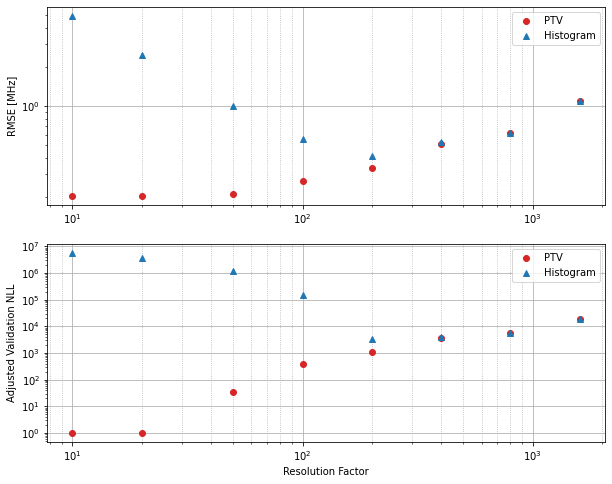

In [14]:
fig,ax_lst = plt.subplots(2,1,figsize=(10,8))

ax = ax_lst[0]

ax.plot(t_res_lst,1e-6*np.array(ptv_rmse_raw_lst),'oC3',label='PTV')
ax.plot(t_res_lst,1e-6*np.array(mcs_rmse_raw_lst),'^C0',label='Histogram')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlabel('Resolution Factor')
ax.set_ylabel('RMSE [MHz]')
ax.grid(visible=True)
ax.grid(which='minor',linestyle=':',axis='x')
ax.legend()

ax = ax_lst[1]

min_adj = np.min(ptv_vld_raw_lst)-1e0
ax.plot(t_res_lst,np.array(ptv_vld_raw_lst)-min_adj,'oC3',label='PTV')
ax.plot(t_res_lst,np.array(mcs_vld_raw_lst)-min_adj,'^C0',label='Histogram')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Resolution Factor')
ax.set_ylabel('Adjusted Validation NLL')
ax.grid(visible=True)
ax.grid(which='minor',linestyle=':',axis='x')
# ax.set_xticks(minor=True)
ax.minorticks_on()
ax.legend()

# plt.savefig(os.path.join(os.environ['HOME'],"MPD/ptv_tt_figs",'ptv-c2f-hr_paper',"Fig4_simulated_2d_eval.jpg"),dpi=300,bbox_inches='tight')

In [15]:
ptv_vld_raw_lst = []
ptv_rmse_raw_lst = []
ptv_vld_dwnsmp_lst = []
ptv_rmse_dwnsmp_lst = []


mcs_vld_raw_lst = []
mcs_rmse_raw_lst = []
mcs_vld_dwnsmp_lst = []
mcs_rmse_dwnsmp_lst = []

t_res_lst = []
r_res_lst = []

res_str_lst = []
tres_str_lst = []
rres_str_lst = []

plt_time_lst = []
plt_range_lst = []
rho_est_lst = []
hist_est_lst = []
rho_low_est_lst = []
hist_low_est_lst = []

first_bl = True
for file_idx,ptv_file in enumerate(ptv_file_lst):
    ptv_ds = xr.open_dataset(ptv_file)
    res_idx=0
    res_str = str(ptv_ds['resolution_t_set'].values[res_idx])+'x'+str(ptv_ds['resolution_r_set'].values[res_idx])
    tres_str = str(ptv_ds['resolution_t_set'].values[res_idx])
    rres_str = str(ptv_ds['resolution_r_set'].values[res_idx])
    
    res_str_lst.append(res_str)
    tres_str_lst.append(tres_str)
    rres_str_lst.append(rres_str)
    
    print('%d.) '%file_idx+ptv_file.split(os.sep)[-1] + ', ' + res_str)
    if first_bl:
        raw_ds = xr.open_dataset(os.path.join(data_path,'simulations',ptv_ds.attrs['data_filename']))
        
        time_axis_raw = raw_ds.attrs['time_resolution']*np.arange(raw_ds.dims['time1'])
        range_axis_raw = raw_ds.attrs['bin_wid']*np.arange(raw_ds.dims['range1'])
        shot_count_raw = raw_ds['y_i_trn_chan0_res1x1_run0'].values.squeeze()[:,0:1]
        bin_resolution_raw = raw_ds.attrs['bin_wid']  # range bin resolution in s
        backscat_true = raw_ds['x_true_backscatter1'].values
        
    plt_time = np.arange(ptv_ds.dims['time'+tres_str]+1)*ptv_ds.attrs['time_resolution']*ptv_ds['resolution_t_set'].values[res_idx]
    plt_range = np.arange(ptv_ds.dims['range'+tres_str]+1)*ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]
    
    plt_time_lst.append(plt_time)
    plt_range_lst.append(plt_range)
    
    ### Base (down sampled) resolution analysis
    
    time_axis = ptv_ds.attrs['time_resolution']*ptv_ds['resolution_t_set'].values[res_idx]*np.arange(ptv_ds.dims['time'+tres_str])
    range_axis = ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]*np.arange(ptv_ds.dims['range'+rres_str])
    shot_count = ptv_ds['y_i_trn_chan0_res'+res_str].values.squeeze()[:,0:1]
    bin_resolution = ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]  # range bin resolution in s
    
    rho_est_dwnsmp = ptv_ds['tcspc_sol_backscatter_res'+res_str].values.squeeze()
    hist_est_dwnsmp = ptv_ds['y_p_trn_chan0_res'+res_str].values.squeeze()/shot_count/bin_resolution
    
    rho_low_est_lst.append(rho_est_dwnsmp)
    hist_low_est_lst.append(hist_est_dwnsmp)
    
    ptv_rmse = np.sqrt(np.mean((ptv_ds['x_true_backscatter'+res_str].values-rho_est_dwnsmp)**2))
    hist_rmse = np.sqrt(np.mean((ptv_ds['x_true_backscatter'+res_str].values-hist_est_dwnsmp)**2))
    
    ptv_vld = np.sum(ptv_ds['y_i_vld_chan1_res'+res_str].values.squeeze()*rho_est_dwnsmp*ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]
                     - ptv_ds['y_p_vld_chan1_res'+res_str].values.squeeze()*np.log(rho_est_dwnsmp))
    hist_vld = np.sum(ptv_ds['y_i_vld_chan1_res'+res_str].values.squeeze()*hist_est_dwnsmp*ptv_ds.attrs['bin_wid']*ptv_ds['resolution_r_set'].values[res_idx]
                      - ptv_ds['y_p_vld_chan1_res'+res_str].values.squeeze()*np.log(hist_est_dwnsmp+1e-20))
    ptv_vld_dwnsmp_lst.append(ptv_vld)
    ptv_rmse_dwnsmp_lst.append(ptv_rmse)

    mcs_vld_dwnsmp_lst.append(hist_vld)
    mcs_rmse_dwnsmp_lst.append(hist_rmse)
    
    t_res_lst.append(ptv_ds['resolution_t_set'].values[res_idx])
    r_res_lst.append(ptv_ds['resolution_r_set'].values[res_idx])
    
    ptv_ds.close()

0.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T064701.nc, 800x800
1.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T065524.nc, 400x400
2.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T071034.nc, 200x200
3.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T073512.nc, 100x100
4.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T081311.nc, 50x50
5.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T103853.nc, 20x20
6.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221106T131848.nc, 10x10
7.) timetag_hist_ptv_rt_sim_20221106T063211_RunOn20221107T123917.nc, 1600x1600


Figure 3

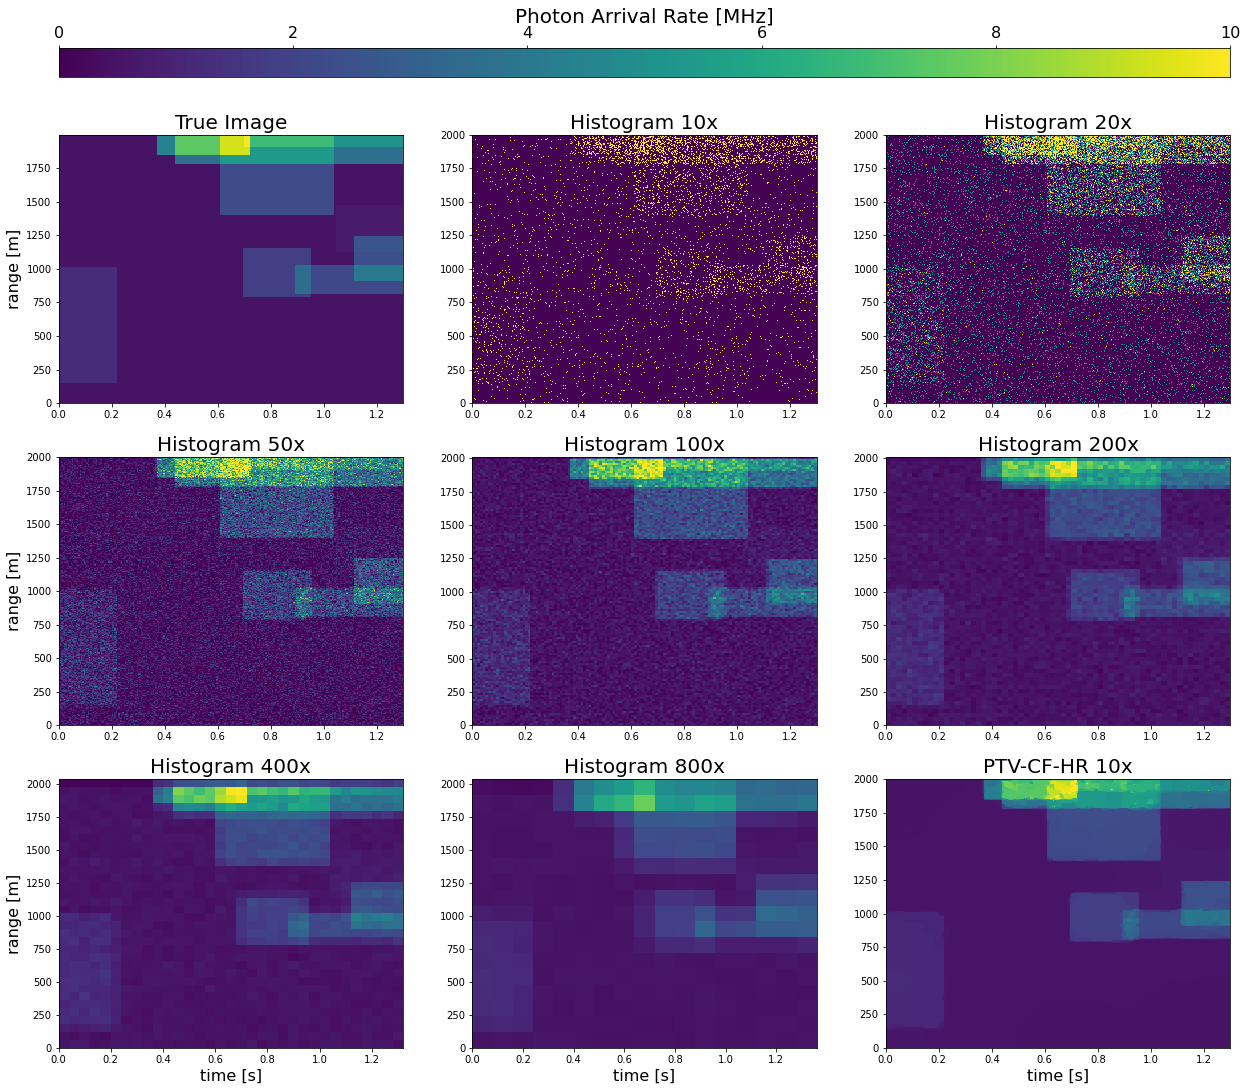

In [18]:
# find the order of resolution
res_order_idx = np.argsort(t_res_lst[:-1])

offset = 1  # axis index offset to account for placement of PTV and True images
            # when placing both in front, set to 2
            # if only one in front, set to 1

cax_mult = 1e-6
# plt_kwargs = {'norm':LogNorm(vmin=1e5*cax_mult,vmax=2e7*cax_mult)}  # log color axis
plt_kwargs = {'vmin':0*cax_mult,'vmax':1e7*cax_mult}   # linear color axis

fig,ax_lst = plt.subplots(3,3,figsize=(21,21))
ax_lst = ax_lst.ravel()

# plot the histogram estimates
for plt_idx,idx in enumerate(res_order_idx):
    hist_plt = hist_low_est_lst[idx]
    im1 = ax_lst[plt_idx+offset].pcolormesh(plt_time_lst[idx],plt_range_lst[idx]*3e8/2,hist_plt.T*cax_mult,**plt_kwargs)
    if plt_idx+offset > 5:
        ax_lst[plt_idx+offset].set_xlabel('time [s]',fontsize=16)
    if np.mod(plt_idx+offset,3) == 0:
        ax_lst[plt_idx+offset].set_ylabel('range [m]',fontsize=16)
    
    ax_lst[plt_idx+1].set_title('Histogram '+tres_str_lst[idx]+'x',fontsize=20)


# PTV-CF-HR at highest resolution
im1 = ax_lst[-1].pcolormesh(plt_time_lst[res_order_idx[0]],plt_range_lst[res_order_idx[0]]*3e8/2,rho_low_est_lst[res_order_idx[0]].T*cax_mult,**plt_kwargs)
ax_lst[-1].set_title('PTV-CF-HR '+tres_str_lst[res_order_idx[0]]+'x',fontsize=20)
ax_lst[-1].set_xlabel('time [s]',fontsize=16)

# true image
im1 = ax_lst[0].pcolormesh(mesh_axis(time_axis_raw),mesh_axis(range_axis_raw)*3e8/2,backscat_true.T*cax_mult,**plt_kwargs)
ax_lst[0].set_title('True Image',fontsize=20)
ax_lst[0].set_ylabel('range [m]',fontsize=16)

if cax_mult == 1e-6:
    unit_str = 'MHz'
else:
    unit_str = 'Hz'
cb = fig.colorbar(im1, ax=ax_lst.tolist(),location='top',aspect=40,)
cb.set_label(label='Photon Arrival Rate ['+unit_str+']', fontsize=20,)
cb.ax.tick_params(labelsize=16) 

# plt.savefig(os.path.join(os.environ['HOME'],'MPD/ptv_tt_figs','ptv-c2f-hr_paper',
#                          'Fig3_simulated_2d_example_res_compare'+'.jpg'),dpi=300,bbox_inches='tight')

# Perform Analysis of MPD Data
Used to generate Figures 5, 6 and 7

In [4]:
time_tag_path = "/scr/fog1/rsfdata/MPD/mpd_01_processed_data/time_tag_data/timetag"
histogram_path = "/scr/fog1/rsfdata/MPD/mpd_01_processed_data/time_tag_data/histogram"

tmp_data_path = "/scr/fog1/rsfdata/MPD/mpd_01_processed_data/time_tag_data/ptv/20210819_075053"  # poisson demo case

In [5]:
laser_pulse_width = 0.625e-6  # mpd laser pulse length in time
c = 299792458.0  # the speed of light in a vaccume

In [6]:
def time_down_sample(a:np.ndarray,down_int:int):
    """
    down sample an array in time (0 axis) by a factor of down_int
    the down sampling is performed by summing (not averaging)
    a: np.ndarray
        array to be down sampled
    down_int: int
        down sampling factor
    """
    if down_int > 1:
        cat_len = int(np.ceil(a.shape[0]/down_int)*down_int-a.shape[0])
        if cat_len > 0:
            cat_nan = np.ones((cat_len,a.shape[1]))*np.nan
            a_full = np.concatenate((a,cat_nan),axis=0)
        else:
            a_full = a
            
        a_down = np.nansum(a_full.T.reshape(a_full.shape[1],a_full.shape[0]//down_int,-1),axis=2).T
    else:
        a_down = a
        
    return a_down

def time_down_sample_mean(a:np.ndarray,down_int:int):
    """
    down sample an array in time (0 axis) by a factor of down_int
    the down sampling is performed by averaging
    a: np.ndarray
        array to be down sampled
    down_int: int
        down sampling factor
    """
    if down_int > 1:
        cat_len = int(np.ceil(a.shape[0]/down_int)*down_int-a.shape[0])
        if cat_len > 0:
            cat_nan = np.ones((cat_len,a.shape[1]))*np.nan
            a_full = np.concatenate((a,cat_nan),axis=0)
        else:
            a_full = a
            
        a_down = np.nanmean(a_full.T.reshape(a_full.shape[1],a_full.shape[0]//down_int,-1),axis=2).T
    else:
        a_down = a
        
    return a_down

def range_down_sample(a:np.ndarray,down_int:int):
    """
    down sample an array in range (1 axis) by a factor of down_int
    the down sampling is performed by summing (not averaging)
    a: np.ndarray
        array to be down sampled
    down_int: int
        down sampling factor
    """
    if down_int > 1:
        cat_len = int(np.ceil(a.shape[1]/down_int)*down_int-a.shape[1])
        if cat_len > 0:
            cat_nan = np.ones((a.shape[0],cat_len))*np.nan
            a_full = np.concatenate((a,cat_nan),axis=1)
        else:
            a_full = a
            
        a_down = np.nansum(a_full.reshape(a_full.shape[0],a_full.shape[1]//down_int,-1),axis=2)
    else:
        a_down = a
    
    return a_down

def range_down_sample_mean(a:np.ndarray,down_int:int):
    """
    down sample an array in range (1 axis) by a factor of down_int
    the down sampling is performed by averaging
    a: np.ndarray
        array to be down sampled
    down_int: int
        down sampling factor
    """
    if down_int > 1:
        cat_len = int(np.ceil(a.shape[1]/down_int)*down_int-a.shape[1])
        if cat_len > 0:
            cat_nan = np.ones((a.shape[0],cat_len))*np.nan
            a_full = np.concatenate((a,cat_nan),axis=1)
        else:
            a_full = a
            
        a_down = np.nanmean(a_full.reshape(a_full.shape[0],a_full.shape[1]//down_int,-1),axis=2)
    else:
        a_down = a
    
    return a_down

def dt64_to_datetime(t:np.datetime64)->datetime.datetime:
    unix_epoch = np.datetime64(0, 's')
    one_second = np.timedelta64(1, 's')
    start_seconds_since_epoch = (t - unix_epoch) / one_second
    t_dt = datetime.datetime.utcfromtimestamp(start_seconds_since_epoch)
    return t_dt

def square_laser_pulse(T,dt,norm=True):
    """
    square_laser_pulse(T,dt)
    Calculate the symmetric convolution kernel for a square pulse
    with
    T = pulse length
    dt = time bin width
    
    returns
    pulse definition in bins
    the pulse index array
    
    """
    
    N = np.ceil(0.5*(T/dt-1))
    pulse_bins = np.arange(-N,N+1,dtype=int)
    pulse = np.minimum(0.5*T/(0.5*dt+dt*np.abs(pulse_bins)),1)
    if norm:
        pulse=pulse/np.sum(pulse)
    
    pulse_bins=pulse_bins[np.newaxis,:]
    pulse = pulse[np.newaxis,:]
    
    return pulse,pulse_bins

List the available data for analysis

In [7]:
data_run_type = 'Backscatter' # 'Backscatter','WaterVapor', 'BGch0', 'BGch4'

# locate the unique processing runs in the temporary directory
file_lst = sorted(glob.glob(os.path.join(tmp_data_path,data_run_type+'*runtime*.nc')))

run_set_lst = []
run_idx = 0
for file in file_lst:
    splt_str = file.split('runtime')
    runstr = splt_str[-1].split('_')[0]
    filestr = 'T'.join(splt_str[-2].split('_')[-3:-1])
    run_datetime = datetime.datetime.strptime(runstr,'%Y%m%dT%H%M%S')
    file_datetime = datetime.datetime.strptime(filestr,'%Y%m%dT%H%M%S')
    if runstr not in run_set_lst:
        run_set_lst.append(runstr)
        file_descr_str = f"{run_idx}.) "
        file_descr_str+=file_datetime.strftime('%Y-%m-%d %H:%M:%S')
        file_descr_str+=" run on " + run_datetime.strftime('%Y-%m-%d %H:%M:%S')
        try:
            ds = xr.open_dataset(file)
            t_bin = ds.attrs['time_bin_combined']
            r_bin = ds.attrs['range_bin_combined']
            t_dwnsmp = ds.attrs['time_downsample_factor']
            r_dwnsmp = ds.attrs['range_downsample_factor']
            noise_str = ds.attrs.get('noise_model','deadtime')
            if ds.attrs.get('deadtime_corrected','False')=='True':
                noise_str+='-corrected'
            if ds.attrs.get('deconvolve',1) > 0:
                deconv_str = ", deconv: True"
            else:
                deconv_str = ", deconv: False"
                
            file_descr_str+=f" bins ({t_bin},{r_bin}), down sample ({t_dwnsmp},{r_dwnsmp}), "+noise_str+deconv_str
        except:
            pass
        print(file_descr_str)
        run_idx = run_idx+1

0.) 2021-08-19 07:50:53 run on 2022-09-22 14:08:37 bins (200,10), down sample (1,1), poisson, deconv: True
1.) 2021-08-19 07:50:53 run on 2022-09-22 14:13:00 bins (100,5), down sample (1,1), poisson, deconv: True
2.) 2021-08-19 07:50:53 run on 2022-09-22 14:29:19 bins (50,5), down sample (1,1), poisson, deconv: True
3.) 2021-08-19 07:50:53 run on 2022-09-22 14:30:56 bins (100,3), down sample (1,1), poisson, deconv: True
4.) 2021-08-19 07:50:53 run on 2022-09-22 14:34:14 bins (50,3), down sample (1,1), poisson, deconv: True
5.) 2021-08-19 07:50:53 run on 2022-09-22 16:20:44 bins (24,3), down sample (1,1), poisson, deconv: True
6.) 2021-08-19 07:50:53 run on 2022-09-22 16:22:17 bins (50,2), down sample (1,1), poisson, deconv: True
7.) 2021-08-19 07:50:53 run on 2022-09-22 16:24:24 bins (24,2), down sample (1,1), poisson, deconv: True
8.) 2021-08-19 07:50:53 run on 2022-11-04 10:10:11 bins (24,5), down sample (1,1), poisson, deconv: True
9.) 2021-08-19 07:50:53 run on 2022-11-04 14:37:24 

80.) 2021-08-19 07:50:53 run on 2023-01-05 18:04:17 bins (2,1), down sample (1,1), poisson, deconv: True
81.) 2021-08-19 07:50:53 run on 2023-01-05 19:58:59 bins (4,1), down sample (1,1), poisson, deconv: True
82.) 2021-08-19 07:50:53 run on 2023-01-06 08:28:47 bins (2,1), down sample (1,1), poisson, deconv: True
83.) 2021-08-19 07:50:53 run on 2023-01-06 09:20:02 bins (256,128), down sample (1,1), poisson, deconv: True
84.) 2021-08-19 07:50:53 run on 2023-01-06 09:24:44 bins (512,128), down sample (1,1), poisson, deconv: True
85.) 2021-08-19 07:50:53 run on 2023-01-06 09:27:22 bins (1024,128), down sample (1,1), poisson, deconv: True
86.) 2021-08-19 07:50:53 run on 2023-01-06 09:29:46 bins (2048,128), down sample (1,1), poisson, deconv: True
87.) 2021-08-19 07:50:53 run on 2023-01-06 09:32:04 bins (4096,128), down sample (1,1), poisson, deconv: True


In [24]:
### C2F Diagonal (Figures 5, 6, 7) ###
run_tag_lst = []
desig_lst = []  # marker designation for some plots

# # 1 x 1 
run_tag_lst += ['20221214T112152','20221214T121651','20221214T123952',
                '20221214T134455','20221215T095040','20221217T065122','20221222T080251',]
desig_lst += [0]*7

# # 1 x 2
run_tag_lst += ['20221214T111253','20221214T121208','20221214T123555','20221214T125049',
                '20221217T064655','20221218T064026','20221222T080527',]
desig_lst += [5]*7

# # 2 x 1 
run_tag_lst += ['20221214T103316','20221214T114037','20221214T114446','20221214T115445',
                '20221216T190800','20221217T065913','20221220T070750',]
desig_lst += [1]*7

# # 4 x 1 
run_tag_lst += ['20221214T131513','20221214T132523','20221214T132832','20221214T133345',
                '20221214T201834','20221216T190152','20221218T064322',]
desig_lst += [2]*7

# # 8 x 1 
run_tag_lst += ['20221214T140042','20221214T184141','20221214T184744','20221214T185209',
                '20221214T190129','20221216T123834','20221217T073019',]
desig_lst += [3]*7

# # 16 x 1 
run_tag_lst += ['20221223T082242','20221223T082545','20221223T082929','20221223T083304',
                '20221223T083653','20221223T085040','20221224T061151',]
desig_lst += [4]*7



### plot time resolution c2f only (Figure 8) ###
# run_tag_lst = []
# desig_lst = []  # marker designation for some plots

# # 1 x 1 
# run_tag_lst += ['20221222T080251',]
# desig_lst += [0]

# # # 2 x 1 
# run_tag_lst += ['20221220T070750','20230104T194650',]
# desig_lst += [1]*2

# # # 4 x 1 
# run_tag_lst += ['20221218T064322','20230103T071058','20230104T072003',]
# desig_lst += [2]*3

# # # 8 x 1 
# run_tag_lst += ['20221217T073019','20221224T062821','20230104T194326','20230105T180417',]
# desig_lst += [3]*4

# # # 16 x 1 
# desig_lst += [4]*5
# run_tag_lst += ['20221224T061151','20230104T195120','20230105T080638','20230105T195859','20230106T082847',]


In [115]:
ds_lst = []
vld_loss_lst = []
mcs_vld_loss_lst = []
range_bin_lst = []
time_bin_lst = []
range_downsamp_lst = []
time_downsamp_lst = []
rho_sol_lst = []
mcs_sol_lst = []
fwd_model_lst = []
noise_model_lst = [] # 1 - deadtime, 2 - poisson, 3 - poisson corrected
noise_model_label = {1:'Deadtime',2:'Poisson',3:'Poisson Corrected'}

mcs_cnt_lst = []
mcs_raw_cnt_lst = []

range_low_res = 37.5 # 37.5
time_low_res = 10.0  # 60.0
rho_sol_low_res_lst = []
fwd_sol_low_res_lst = []
mcs_low_res_lst = []
count_low_res_lst = []
dr_low_res_lst = []
dt_low_res_lst = []


# composites of down sampling and binning
time_res_lst = []
range_res_lst = []

runtime_tag_lst = []

proc_duration_mean = []
proc_duration_max = []
proc_duration_min = []

ic_bin_lst = []
ic_tag_lst = []

first_run = True

# for set_sel_idx in eval_file_lst:
for run_tag in run_tag_lst:
    validation_lst = []
    alpha_dct = {}
    run_time_lst = []
    file_lst = glob.glob(os.path.join(tmp_data_path,data_run_type+'*runtime'+run_tag+'*.nc'))
    runtime_tag_lst.append(run_tag)
    
    file_lst_sort = []
    run_idx = 0
    file_cnt = 0
    load_noise_model = True
    while file_cnt < len(file_lst):
        filestr = list(filter(lambda x: f"aidx{run_idx}.nc" in x, file_lst))
        if len(filestr) > 0:
            assert len(filestr) < 2
            file_cnt +=1
            file_lst_sort.append(filestr[0])
#             print(filestr[0].split(os.sep)[-1])

            try:
                ds = xr.open_dataset(filestr[0])      
            
                # determine noise model
                if load_noise_model:
                    noise_str = ds.attrs.get('noise_model','deadtime').lower()
                    if noise_str == 'deadtime':
                        noise_model_id = 1
                    elif noise_str == 'poisson':
                        noise_model_id = 2
                        if ds.attrs.get('deadtime_corrected','False')=='True':
                            noise_model_id += 1
                    else:
                        # unknown noise model
                        noise_model_id = 0
                    load_noise_model=False
                    
                validation_lst.append(ds['validation_nll'].values.min())
                for var in ds['validation_nll'].dims:
                    if var in alpha_dct:
                        alpha_dct[var].append(ds[var].values.min())
                    else:
                        alpha_dct[var] = [ds[var].values.min()]
                run_time_lst.append(ds.attrs.get('process_time_seconds',np.nan)/3600.0)
            except OSError:
                print("could not open "+filestr[0].split(os.sep)[-1])

        run_idx += 1
        
    noise_model_lst.append(noise_model_id)
    proc_duration_mean.append(np.mean(run_time_lst))
    proc_duration_min.append(np.min(run_time_lst))
    proc_duration_max.append(np.max(run_time_lst))
    
    
    # open the result that validates best
    isol = np.argmin(validation_lst)
    ds = xr.open_dataset(file_lst_sort[isol])
    
    if first_run:
        time_bin_comb = 2

        # load the raw validation data
        raw_time_slc = slice(ds.attrs['time_min_idx'],ds.attrs['time_max_idx'])
        raw_range_slc = slice(ds.attrs['range_min_idx'],ds.attrs['range_max_idx'])
        raw_range_bin_slc = slice(ds.attrs['range_min_idx'],ds.attrs['range_max_idx']+1)

        ds_lst = []
        for raw_data_file in ds.attrs['data_files'].split(', '):
            print("loading "+raw_data_file)
            print("from "+histogram_path)
            ds_tmp = xr.open_dataset(os.path.join(histogram_path,raw_data_file))
            ds_tmp = ds_tmp.isel(range=raw_range_slc)
            ds_tmp = ds_tmp.isel(range_bin_edges = raw_range_bin_slc)
            ds_lst.append(ds_tmp.isel(time=np.where(ds_tmp['sync_bin_count']>0)[0]))
            ds_tmp.close()

        raw_ds = xr.concat(ds_lst,dim='time',data_vars='different')
        
        # grab the raw time tag representation
        tt_from_hist = np.where(raw_ds['y_ch0_d_th0'].isel(time=raw_time_slc) > 0)
        tt_range = raw_ds['range'].values[tt_from_hist[1]]
        tt_time = raw_ds['time'].isel(time=raw_time_slc).values[tt_from_hist[0]]
        tt_time_axis = (tt_time-tt_time[0]).astype(float)*1e-9

        MPDnumber = ds.attrs['MPDnumber']
        LidarName = f"MPD0{MPDnumber}"

        file_date = dt64_to_datetime(np.datetime64(int(ds['time'].values[0]*1e-9),'s'))

        ch = 0
        thn_idx = 1 # validation index

        dt_lam = raw_ds.attrs['range_bin_width']
        
        y_int_vld = time_down_sample(raw_ds['y_ch%d_i_th%d'%(ch,thn_idx)].isel(time=raw_time_slc).values*dt_lam,2)
        y_d_vld = time_down_sample(raw_ds['y_ch%d_d_th%d'%(ch,thn_idx)].isel(time=raw_time_slc).values,2)

        vld_shape = y_d_vld.shape

        time_bin_centers_raw = raw_ds['time_bin_centers'].values[raw_time_slc]
        if time_bin_comb > 1:
            time_bin_edges = np.unique(np.concatenate((time_bin_centers_raw[::time_bin_comb],time_bin_centers_raw[-1:])))
            time_bin_centers = 0.5*(time_bin_edges[:-1]+time_bin_edges[1:])
        else:
            time_bin_centers = time_bin_centers_raw
            dt = np.diff(time_bin_centers)
            time_bin_edges = np.zeros(time_bin_centers.size+1)
            time_bin_edges[1:-1] = time_bin_centers[1:]-0.5*dt
            time_bin_edges[0] = time_bin_centers[0] - 0.5*dt[0]
            time_bin_edges[-1] = time_bin_centers[-1] + 0.5*dt[-1]

        laser_pulse,pulse_bins = square_laser_pulse(laser_pulse_width,dt_lam,norm=True)
        conv_mask = np.ones(vld_shape)
        conv_mask[:,:laser_pulse.size//2+1] = 0
        conv_mask[:,-laser_pulse.size//2-1:] = 0

        dr0 = dt_lam*c/2
        dt0 = np.median(np.diff(time_bin_centers))*1e-9/2

        # raw_ds.attrs['sync_time_spacing']
        mask_idx = np.where(conv_mask==0)
        range_idx = np.where(conv_mask[0,:] == 1)[0]
        rho_image_slc = slice(range_idx.min(),range_idx.max()+1)
        range_bins = raw_ds['range_bin_edges'].values[np.concatenate((range_idx,np.array([range_idx[-1]+1])))]

        time_axis = (time_bin_edges - time_bin_edges[0])*1e-9

        time_dt = np.datetime64(int(raw_ds['time'].values[0]),'ns')
        time_str = str(time_dt).replace('T',', ')[:20]

        first_run = False
        # end of loading validation data
    
    
    
    ds_lst.append(ds)
    
    # get the resolution of the initial conditions used
    # for this processing run
    if len(ds.attrs['initial_condition_runtime_tag']) > 0:
        ic_tag_lst.append(ds.attrs['initial_condition_runtime_tag'])
        ic_file_lst = glob.glob(os.path.join(tmp_data_path,data_run_type+'*runtime'+ds.attrs['initial_condition_runtime_tag']+'*.nc'))
        ic_ds = xr.open_dataset(ic_file_lst[0])
        ic_bin_comb = [ic_ds.attrs['time_bin_combined'],ic_ds.attrs['range_bin_combined']]
        ic_bin_lst.append(ic_bin_comb)
        ic_ds.close()
    else:
        ic_bin_lst.append([None,None])
        ic_tag_lst.append("")
    # upsample forward model to base bin resolution
    t_resample_1_int = np.maximum(ds.attrs['time_bin_combined']//2,1)
    t_resample_2_int = 1 # np.maximum(ds_val.attrs['time_bin_combined']//2,1)
    r_resample_1_int = np.maximum(ds.attrs['range_bin_combined'],1)
    r_resample_2_int = 1 # np.maximum(ds_val.attrs['range_bin_combined'],1)

    raw_shape = (ds.attrs['time_max_idx']-ds.attrs['time_min_idx'], 
                 ds.attrs['range_max_idx']-ds.attrs['range_min_idx'])  # raw data shape
    fwd_lam = range_down_sample_mean(
                time_down_sample_mean(
                    range_up_sample(
                        time_up_sample(ds['fwd_model'].values.squeeze(),t_resample_1_int,raw_shape[0]//2),
                        r_resample_1_int,raw_shape[1]),
                    t_resample_2_int),
                r_resample_2_int)[:vld_shape[0],:vld_shape[1]]
    
    rho_resamp = range_down_sample_mean(
                    time_down_sample_mean(
                        range_up_sample(
                            time_up_sample(ds['ptv_rho'].values.squeeze(),t_resample_1_int,raw_shape[0]//2),
                            r_resample_1_int,raw_shape[1]),
                        t_resample_2_int),
                    r_resample_2_int)[:vld_shape[0],:vld_shape[1]]
    
    ch = 0
    if noise_model_id == 1:
        mcs_rate_da = (ds['y_d_trn']/ds['y_i_trn']) #  - ds['rho_bg']
    else:
        mcs_rate_da = ds['y_d_trn']/(ds.attrs['range_bin_width']*ds['y_c_trn']) #  - ds['rho_bg']
        
    mcs_resamp = range_down_sample_mean(
                    time_down_sample_mean(
                        range_up_sample(
                            time_up_sample(mcs_rate_da.values.squeeze(),t_resample_1_int,raw_shape[0]//2),
                            r_resample_1_int,raw_shape[1]),
                        t_resample_2_int),
                    r_resample_2_int)[:vld_shape[0],:vld_shape[1]]
    mcs_cnt_resamp = range_down_sample_mean(
                    time_down_sample_mean(
                        range_up_sample(
                            time_up_sample(ds['y_d_trn'].values.squeeze(),t_resample_1_int,raw_shape[0]//2),
                            r_resample_1_int,raw_shape[1]),
                        t_resample_2_int),
                    r_resample_2_int)[:vld_shape[0],:vld_shape[1]]
    
    t_low_res_int = int(np.round(time_low_res/(ds.attrs['time_bin_combined']/100)))
    r_low_res_int = int(np.round((range_low_res*2/c)/(ds.attrs['range_bin_combined']*5e-9)))
    mcs_low_res = range_down_sample(
                    time_down_sample(
                            ds['y_d_trn'].values,
                        t_low_res_int),
                r_low_res_int)

    count_low_res = time_down_sample(
                            ds['y_c_trn'].values[:,np.newaxis],
                        t_low_res_int)
    
    rho_low_res = range_down_sample_mean(
                    time_down_sample_mean(
                            ds['ptv_rho'].values.squeeze(),
                        t_low_res_int),
                r_low_res_int)
    fwd_low_res = range_down_sample_mean(
                    time_down_sample_mean(
                            ds['fwd_model'].values.squeeze(),
                        t_low_res_int),
                r_low_res_int)
    
    rho_sol_low_res_lst.append(rho_low_res)
    fwd_sol_low_res_lst.append(fwd_low_res)
    mcs_low_res_lst.append(mcs_low_res)
    count_low_res_lst.append(count_low_res)
    dr_low_res_lst.append(r_low_res_int)
    dt_low_res_lst.append(t_low_res_int)
    
    mcs_raw_cnt_lst.append(ds['y_d_trn'].values.squeeze())
    mcs_cnt_lst.append(mcs_cnt_resamp)
    
    # calculate validation loss
    vld_loss_lst.append(np.sum(conv_mask*(y_int_vld*fwd_lam-y_d_vld*np.log(fwd_lam))))
    mcs_vld_loss_lst.append(np.nansum(conv_mask*(y_int_vld*mcs_resamp-y_d_vld*np.log(mcs_resamp+1e-20))))
    
    rho_sol_lst.append(rho_resamp)
    fwd_model_lst.append(fwd_lam)
    mcs_sol_lst.append(mcs_resamp)
    
    # store all the resolution information
    range_bin_lst.append(ds.attrs['range_bin_combined'])
    time_bin_lst.append(ds.attrs['time_bin_combined'])
    range_downsamp_lst.append(ds.attrs['range_downsample_factor'])
    time_downsamp_lst.append(ds.attrs['time_downsample_factor'])
    range_res_lst.append(ds.attrs['range_bin_combined']*ds.attrs['range_downsample_factor'])
    time_res_lst.append(ds.attrs['time_bin_combined']*ds.attrs['time_downsample_factor'])
    
    ds.close()

loading Histogram_01_20210819_075053.nc
from /scr/fog1/rsfdata/MPD/mpd_01_processed_data/time_tag_data/histogram
loading Histogram_01_20210819_075340.nc
from /scr/fog1/rsfdata/MPD/mpd_01_processed_data/time_tag_data/histogram


In [116]:
time_bin_arr = np.array(time_bin_lst)*dt0
range_bin_arr = np.array(range_bin_lst)*dr0

time_res_arr = np.array(time_res_lst)*dt0
range_res_arr = np.array(range_res_lst)*dr0

In [117]:
marker_lst = ['o','s','^','d','<','x','>']
marker_color_lst = ['tab:blue','tab:green','tab:orange','tab:red','tab:purple','tab:brown','tab:gray']

Figure 8

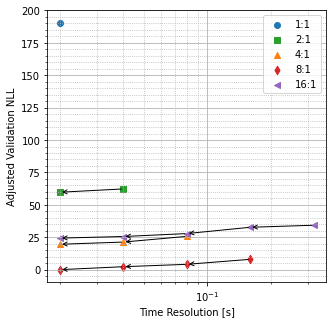

In [95]:
desig_lst
desig_label = ['1:1','2:1','4:1','8:1','16:1']
# marker_color_lst = ''

vld_adj = np.min(vld_loss_lst)

fig,ax = plt.subplots(1,1,figsize=(5,5))

for idx,marker_idx in enumerate(np.unique(np.array(desig_lst))):
    label_str = desig_label[marker_idx]
    data_idx = np.where(np.array(desig_lst)==marker_idx)[0]
    
    ax.scatter(time_res_arr[data_idx],np.array(vld_loss_lst)[data_idx]-vld_adj,c=marker_color_lst[idx],alpha=1.0,label=label_str,marker=marker_lst[idx])

    
ax.set_xlabel('Time Resolution [s]')
ax.set_ylabel('Adjusted Validation NLL')
ax.set_xscale('log')
ax.minorticks_on()
ax.grid(which='minor',linestyle=':')
ax.grid(b=True)
ax.legend()



# plot arrows of coarse-to-fine processing
for idx,ic_bin in enumerate(ic_bin_lst):
    if ic_tag_lst[idx] in runtime_tag_lst:
        ic_idx = runtime_tag_lst.index(ic_tag_lst[idx])
        if ic_bin[0] is not None and ic_bin[1] is not None:
            ax.annotate("", xy=(time_bin_lst[idx]*dt0, vld_loss_lst[idx]-vld_adj), 
                        xytext=(ic_bin[0]*dt0, vld_loss_lst[ic_idx]-vld_adj),
                        arrowprops=dict(arrowstyle="->"))

# plt.savefig(os.path.join(os.environ['HOME'],'MPD/ptv_tt_figs','ptv-c2f-hr_paper',
#                          'Fig8_VLL_TimeOnlyC2F_CompareIC_MPD01_20210819_075053'+'.jpg'),dpi=300,bbox_inches='tight')

Figure 6

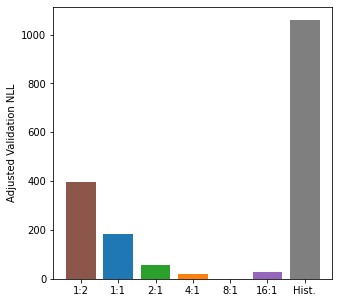

In [118]:
desig_label = ['1:1','2:1','4:1','8:1','16:1','1:2','Hist.']
plt_order = [5,0,1,2,3,4,6]

val_nll_lst = []

fig,ax = plt.subplots(1,1,figsize=(5,5))
plt_order
# for idx,marker_idx in enumerate(np.unique(np.array(desig_lst))):
for idx,marker_idx in enumerate(plt_order):
    label_str = desig_label[marker_idx]
    data_idx = np.where(np.array(desig_lst)==marker_idx)[0]
    
    if 'Hist' in desig_label[marker_idx]:
        val_nll_eval = np.array(mcs_vld_loss_lst)
    else:
        val_nll_eval = np.array(vld_loss_lst)[data_idx]
    
    pnt_idx = np.argmin(val_nll_eval)
    
    val_nll_lst.append(val_nll_eval[pnt_idx])
    

ax.bar(np.array(desig_label)[plt_order],height=np.array(val_nll_lst)-(np.min(val_nll_lst)-1),color=np.array(marker_color_lst)[plt_order])
    
ax.set_ylabel('Adjusted Validation NLL')
ax.grid(which='minor',linestyle=':')

# plt.savefig(os.path.join(os.environ['HOME'],'MPD/ptv_tt_figs','ptv-c2f-hr_paper',
#                          'Fig6_VLL_C2F_CompareICFinalNLL_MPD01_20210819_075053'+'.jpg'),dpi=300,bbox_inches='tight')

Figure 7

Plotting 0.02 s x 1.4989622900000001 m
Plotting 0.02 s x 0.7494811450000001 m
Plotting 0.04 s x 0.7494811450000001 m
Plotting 0.08 s x 0.7494811450000001 m
Plotting 0.16 s x 0.7494811450000001 m
Plotting 0.32 s x 0.7494811450000001 m
Plotting 5.12 s x 47.966793280000005 m


Text(0.5, 1.0, 'Time Tags')

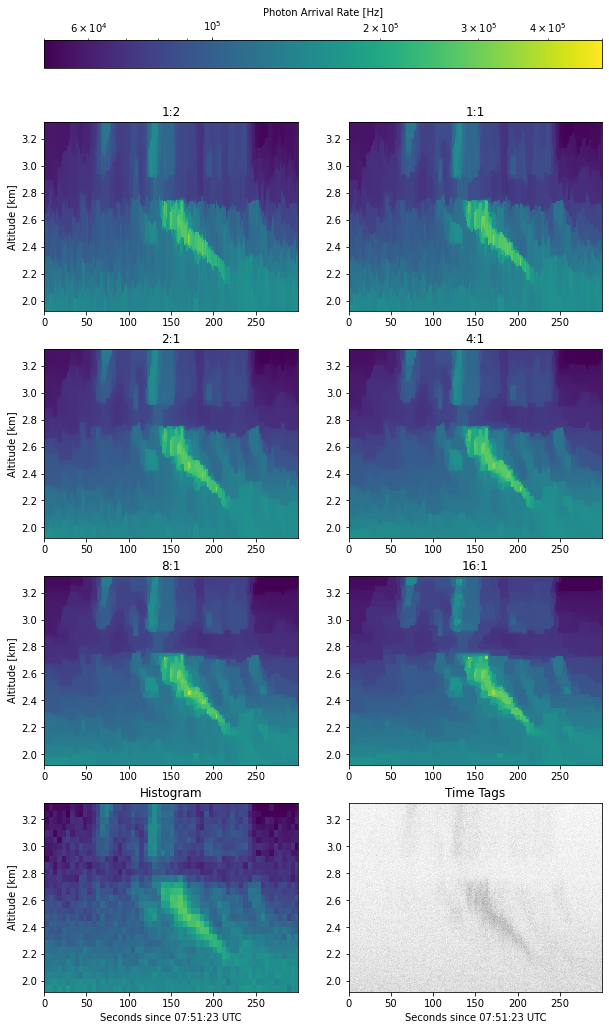

In [119]:
desig_label = ['1:1','2:1','4:1','8:1','16:1','1:2','Histogram']
plt_order = [5,0,1,2,3,4,6]

rho_plt_lst = []
val_nll_lst = []

fig,ax = plt.subplots(4,2,figsize=(2*5,2*10))
ax = np.ravel(ax)

for idx,marker_idx in enumerate(plt_order):
    label_str = desig_label[marker_idx]
    
    
    if 'Histogram' in desig_label[marker_idx]:
        data_idx = np.arange(len(desig_lst))
        plt_image_lst = mcs_sol_lst
        val_nll_eval = np.array(mcs_vld_loss_lst)
    else:
        data_idx = np.where(np.array(desig_lst)==marker_idx)[0]
        plt_image_lst = rho_sol_lst
        val_nll_eval = np.array(vld_loss_lst)[data_idx]
    
    pnt_idx = np.argmin(val_nll_eval)
    
    val_nll_lst.append(val_nll_eval[pnt_idx])
    
    img_idx = data_idx[pnt_idx]
    
    plt_image = plt_image_lst[img_idx][:,rho_image_slc].T

    print(f"Plotting {time_res_arr[img_idx]} s x {range_res_arr[img_idx]} m")
    

    time_dt = np.datetime64(int(time_bin_edges[0]),'ns')
    time_str = str(time_dt).replace('T',', ')[:20]
    im_rho = ax[idx].pcolormesh(time_axis,
                           1e-3*c*range_bins/2,
                           plt_image,
                           norm=LogNorm(vmin=5e4,vmax=5e5),
                           cmap='viridis')

    if np.mod(idx,2) == 0:
        ax[idx].set_ylabel('Altitude [km]')
    if idx > 5:
        ax[idx].set_xlabel('Seconds since '+time_str.split(', ')[-1]+' UTC')
    ax[idx].set_title(desig_label[marker_idx])
    

fig.colorbar(im_rho, ax=ax.tolist(),label='Photon Arrival Rate [Hz]',location='top',aspect=20)


# plot the raw data
raw_data_idx = 0
ax[-1].scatter(tt_time_axis,tt_range*c/2*1e-3,c='k',s=1,alpha=0.003)
ax[-1].set_xlabel('Seconds since '+time_str.split(', ')[-1]+' UTC')
ax[-1].set_xlim(ax[-2].get_xlim())
ax[-1].set_ylim(ax[-2].get_ylim())
ax[-1].set_title('Time Tags')

# plt.savefig(os.path.join(os.environ['HOME'],'MPD/ptv_tt_figs','ptv-c2f-hr_paper',
#                          'Fig7_VLL_C2F_CompareSolutions_MPD01_20210819_075053_vert_3'+'.jpg'),dpi=300,bbox_inches='tight')


Create NLL Contour Plot

In [54]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RationalQuadratic

In [55]:
x_time = np.log(time_res_arr)
t_shift = x_time.min()
x_time = x_time - t_shift
t_scale = x_time.max()
x_time = x_time/t_scale

x_range = np.log(range_res_arr)
r_shift = x_range.min()
x_range = x_range-r_shift
r_scale = x_range.max()
x_range = x_range/r_scale

In [56]:
mesh_size_int = 40

xs1 = np.stack([x_time,x_range],axis=1)
ys1 = np.array(vld_loss_lst).reshape(-1,1)

kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(xs1, ys1)

x1mesh,x2mesh = np.meshgrid(np.linspace(-0.1,1.1,mesh_size_int),np.linspace(-0.1,1.1,mesh_size_int))
x1pred = np.stack([x1mesh.flatten(),x2mesh.flatten()],axis=1)
y1pred = gpr.predict(x1pred)

# guess the minimum
min_idx = np.argmin(y1pred)
x1min = np.exp(x1mesh.flatten()[min_idx]*t_scale+t_shift)
x2min = np.exp(x2mesh.flatten()[min_idx]*r_scale+r_shift)

Figure 6

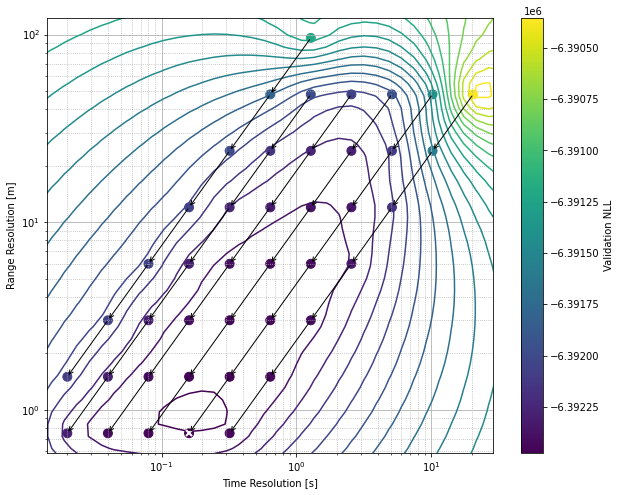

In [57]:
cmap = 'viridis'

plt_idx = len(vld_loss_lst)  # set the max index for plotting (from lowest to highest vld nll)
vld_idx = np.argsort(vld_loss_lst)
lvl_min = vld_loss_lst[vld_idx[0]]
lvl_max = vld_loss_lst[vld_idx[plt_idx-1]]
lvl_arr = np.linspace(lvl_min,lvl_max,20)

fig,ax = plt.subplots(1,1,figsize=(10,8))
im = ax.scatter(time_res_arr[vld_idx[:plt_idx]],
                range_res_arr[vld_idx[:plt_idx]],
                c=np.array(vld_loss_lst)[vld_idx[:plt_idx]],s=80,cmap=cmap)

ax.set_ylabel('Range Resolution [m]')
ax.set_yscale('log')
ax.set_xscale('log')

scatter_clim = im.get_clim()
scatter_xlim = ax.get_xlim()
scatter_ylim = ax.get_ylim()


ax.contour(np.exp(x1mesh*t_scale+t_shift),np.exp(x2mesh*r_scale+r_shift),y1pred.reshape(mesh_size_int,mesh_size_int),
          vmin=scatter_clim[0],vmax=scatter_clim[1],cmap=cmap,levels=lvl_arr)

min_idx = np.argmin(vld_loss_lst)
ax.plot(time_res_arr[min_idx],range_res_arr[min_idx],'wx',markeredgewidth=2)

ax.set_xlim(scatter_xlim)
ax.set_ylim(scatter_ylim)

# plot arrows of coarse-to-fine processing
for idx,ic_bin in enumerate(ic_bin_lst):
    if ic_bin[0] is not None and ic_bin[1] is not None:
        if not (ic_bin[0] == time_bin_lst[idx] and ic_bin[1] == range_bin_lst[idx]):
            if scatter_xlim[1] >= ic_bin[0]*dt0 and scatter_ylim[1] >= ic_bin[1]*dr0:
                ax.annotate("", xy=(time_bin_lst[idx]*dt0, range_bin_lst[idx]*dr0), 
                            xytext=(ic_bin[0]*dt0, ic_bin[1]*dr0),
                            arrowprops=dict(arrowstyle="->"))


ax.set_xlabel('Time Resolution [s]')

ax.minorticks_on()
ax.grid(which='minor',linestyle=':')
ax.grid(b=True)
fig.colorbar(im,label='Validation NLL')

# plt.savefig(os.path.join(os.environ['HOME'],'MPD/ptv_tt_figs','ptv-c2f-hr_paper',
#                          'Fig6_VLL_C2F_MPD01_20210819_075053'+'.jpg'),dpi=300)